### Heart Disease Risk Prediction with Neural Networks

In this notebook, I performed exploratory data analysis on a clinical heart disease dataset, trained a custom neural network module, evaluated its performance, and saved the model along with preprocessing artifacts.

In [2]:
from IPython.display import display

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display
from sklearn.metrics import confusion_matrix, matthews_corrcoef, classification_report

import sys

# Resolve project root and ensure the repo layout exists (src/nn_from_scratch.py)
ROOT = Path.cwd().resolve()
if (ROOT / "src" / "nn_from_scratch.py").exists():
    # Make project root importable (e.g., 'import src...')
    if str(ROOT) not in sys.path: 
        sys.path.insert(0, str(ROOT))
    # Also add 'src' directly (so 'import nn_from_scratch' works if needed)
    if str(ROOT / "src") not in sys.path: 
        sys.path.insert(1, str(ROOT / "src"))
else:
    # Fail fast if the notebook isn't run from the project root
    raise FileNotFoundError("Can't find src/nn_from_scratch.py; run notebook from project root.")

# Library code (from your repo) — the single source of truth
from src.nn_from_scratch import (
    train_val_test_split,
    TargetEncoder, StandardScaler, MinMaxScaler,
    NeuralNetwork, train_model, compute_metrics,
)

# Project metrics/helpers (ROC/PR AUC, threshold tuning)
from src.services.metrics import (
    compute_metrics_from_probs, roc_auc, pr_auc, tune_threshold,
)

# Sanity: show the physical file path being imported
import src.nn_from_scratch as nn_mod
print("Using nn_from_scratch from:", nn_mod.__file__)

Using nn_from_scratch from: /home/marshal/Desktop/nn-from-scratch-main/src/nn_from_scratch.py


#### Exploratory Data Analysis (EDA)

In [3]:
# Verify the dataset exists; fail fast with absolute path if missing
CSV = Path("data/heart_disease.csv")
assert CSV.exists(), f"Missing dataset: {CSV.resolve()}"

# Load CSV and normalize column names by stripping stray whitespace
df = pd.read_csv(CSV)
df.columns = [c.strip() for c in df.columns]

# Ensure classification target is integer (0/1) if present
if "target" in df.columns:
    df["target"] = df["target"].astype(int)

# Quick shape summary and a small head preview for sanity
print(f"Data loaded: {df.shape[0]:,} rows × {df.shape[1]} cols")
display(df.head(3))

Data loaded: 1,048 rows × 13 cols


,Unnamed: 0,age,sex,chest pain type,resting bps,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,2,37,1,2,130,283,0,1,98,0,0.0,1,0


In [4]:
if "Unnamed: 0" in df.columns:
    df.drop(columns=["Unnamed: 0"], inplace=True)

rename_map = {
    "chest pain type": "cp",
    "resting bps": "trestbps",
    "cholesterol": "chol",
    "fasting blood sugar": "fbs",
    "resting ecg": "restecg",
    "max heart rate": "thalach",
    "exercise angina": "exang",
    "ST slope": "slope",
}
df.rename(columns=rename_map, inplace=True)

In [5]:
# Build a summary table with dtype and missingness diagnostics
info_df = pd.DataFrame({
    "Column": df.columns,
    "Dtype": df.dtypes.astype(str).values,      # normalize dtype to string for clean display
    "Missing": df.isna().sum().values,          # count of NaNs per column
    "Missing_%": (df.isna().mean().values * 100).round(2),  # percentage of NaNs
}).sort_values("Missing", ascending=False).reset_index(drop=True)  # most-missing first

print("Dataset info (missing values):")
# Pretty HTML rendering: format percent and hide the row index
display(info_df.style.format({"Missing_%": "{:.2f}%"}).hide(axis="index"))

Dataset info (missing values):


Column,Dtype,Missing,Missing_%
age,int64,0,0.00%
sex,int64,0,0.00%
cp,int64,0,0.00%
trestbps,int64,0,0.00%
chol,int64,0,0.00%
fbs,int64,0,0.00%
restecg,int64,0,0.00%
thalach,int64,0,0.00%
exang,int64,0,0.00%
oldpeak,float64,0,0.00%


In [6]:
# statistical summary (numeric columns only), nicer layout
print("\nStatistical Summary (numeric columns):")
summary = df.describe(include="number").T  # rows = features
display(summary.round(2))


Statistical Summary (numeric columns):


,count,mean,std,min,25%,50%,75%,max
age,1048.0,53.33,9.40,28.0,46.0,54.0,60.0,77.0
sex,1048.0,0.73,0.44,0.0,0.0,1.0,1.0,1.0
cp,1048.0,2.82,1.12,1.0,2.0,3.0,4.0,4.0
trestbps,1048.0,132.61,17.37,92.0,120.0,130.0,140.0,200.0
chol,1048.0,245.17,57.10,85.0,208.0,239.0,275.0,603.0
fbs,1048.0,0.16,0.37,0.0,0.0,0.0,0.0,1.0
restecg,1048.0,0.61,0.76,0.0,0.0,0.0,1.0,2.0
thalach,1048.0,142.92,24.43,69.0,125.0,144.0,162.0,202.0
exang,1048.0,0.37,0.48,0.0,0.0,0.0,1.0,1.0
oldpeak,1048.0,0.94,1.10,-0.1,0.0,0.6,1.6,6.2


In [7]:
# --- Feature info (same logic, nicer display) ---

feature_data = {
    "Variable Name": [
        "Age", "Sex", "Chest Pain Type (cp)", "Resting Blood Pressure (trestbps)",
        "Cholesterol (chol)", "Fasting Blood Sugar (fbs)", "Resting ECG Results (restecg)",
        "Maximum Heart Rate Achieved (thalach)", "Exercise Induced Angina (exang)",
        "ST Depression Induced by Exercise (oldpeak)", "Slope of the ST Segment (slope)", "Target"
    ],
    "Variable Code": ["age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","target"],
    "Description": [
        "Age of the person in years",
        "Gender of the individual (1 = Male, 0 = Female)",
        "Type of chest pain: 1 = typical angina, 2 = atypical angina, 3 = non-anginal pain, 4 = asymptomatic",
        "Resting blood pressure (in mm Hg)",
        "Serum cholesterol level (in mg/dl)",
        "Fasting blood sugar > 120 mg/dl (1 = true, 0 = false)",
        "Resting ECG results: 0 = normal, 1 = ST-T wave abnormality, 2 = left ventricular hypertrophy",
        "Maximum heart rate achieved",
        "Exercise-induced angina (1 = yes, 0 = no)",
        "ST depression induced by exercise relative to rest",
        "Slope of the peak exercise ST segment: 1 = upsloping, 2 = flat, 3 = downsloping",
        "Presence of heart disease (1 = disease, 0 = no disease)"
    ],
    "Domain of Values": [
        "28 to 77", "0 = Female, 1 = Male", "1 to 4", "92 to 200", "85 to 603",
        "0 = false, 1 = true", "0 = normal, 1 = ST-T abnormality, 2 = left ventricular hypertrophy",
        "69 to 202", "0 = no, 1 = yes", "-0.1 to 6.2", "1 to 3", "0 = no disease, 1 = disease"
    ],
    "Type": [
        "Continuous", "Nominal Categorical", "Nominal Categorical", "Continuous", "Continuous",
        "Nominal Categorical", "Nominal Categorical", "Continuous", "Nominal Categorical",
        "Continuous", "Ordinal Categorical", "Nominal Categorical"
    ]
}

# same DataFrame, fixed column order
# build the table
df_feature_info = pd.DataFrame(feature_data)[
    ["Variable Name", "Variable Code", "Description", "Domain of Values", "Type"]
].reset_index(drop=True)   # ← unique index, important

# optional warning if some codes not in df
missing_codes = [c for c in df_feature_info["Variable Code"] if c not in df.columns]
if missing_codes:
    print("Missing in df:", missing_codes)

# nice display (index hidden, long text wraps)
display(
    df_feature_info
      .style
      .hide(axis="index")
      .set_properties(subset=["Description", "Domain of Values"], **{"white-space": "pre-wrap"})
)

Variable Name,Variable Code,Description,Domain of Values,Type
Age,age,Age of the person in years,28 to 77,Continuous
Sex,sex,"Gender of the individual (1 = Male, 0 = Female)","0 = Female, 1 = Male",Nominal Categorical
Chest Pain Type (cp),cp,"Type of chest pain: 1 = typical angina, 2 = atypical angina, 3 = non-anginal pain, 4 = asymptomatic",1 to 4,Nominal Categorical
Resting Blood Pressure (trestbps),trestbps,Resting blood pressure (in mm Hg),92 to 200,Continuous
Cholesterol (chol),chol,Serum cholesterol level (in mg/dl),85 to 603,Continuous
Fasting Blood Sugar (fbs),fbs,"Fasting blood sugar > 120 mg/dl (1 = true, 0 = false)","0 = false, 1 = true",Nominal Categorical
Resting ECG Results (restecg),restecg,"Resting ECG results: 0 = normal, 1 = ST-T wave abnormality, 2 = left ventricular hypertrophy","0 = normal, 1 = ST-T abnormality, 2 = left ventricular hypertrophy",Nominal Categorical
Maximum Heart Rate Achieved (thalach),thalach,Maximum heart rate achieved,69 to 202,Continuous
Exercise Induced Angina (exang),exang,"Exercise-induced angina (1 = yes, 0 = no)","0 = no, 1 = yes",Nominal Categorical
ST Depression Induced by Exercise (oldpeak),oldpeak,ST depression induced by exercise relative to rest,-0.1 to 6.2,Continuous


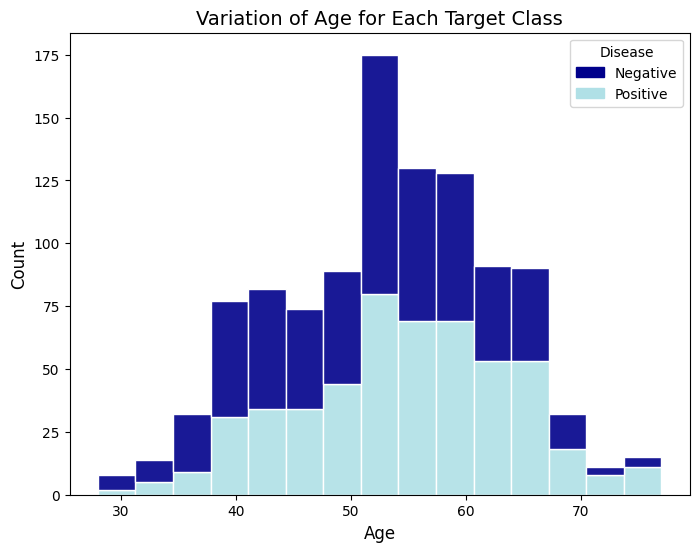

In [8]:
# histogram of age by target (stacked)
plt.figure(figsize=(8, 6))

ax = sns.histplot(
    data=df.dropna(subset=["age", "target"]),
    x="age",
    hue="target",
    multiple="stack",
    bins=15,
    palette={0: "darkblue", 1: "powderblue"},
    edgecolor="white",
    alpha=0.9,
)

plt.title("Variation of Age for Each Target Class", fontsize=14)
plt.xlabel("Age", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.grid(False)

# reliable custom legend (keeps intended colors)
handles = [
    plt.Rectangle((0, 0), 1, 1, color="darkblue"),
    plt.Rectangle((0, 0), 1, 1, color="powderblue"),
]
plt.legend(handles, ["Negative", "Positive"], title="Disease")

plt.show()

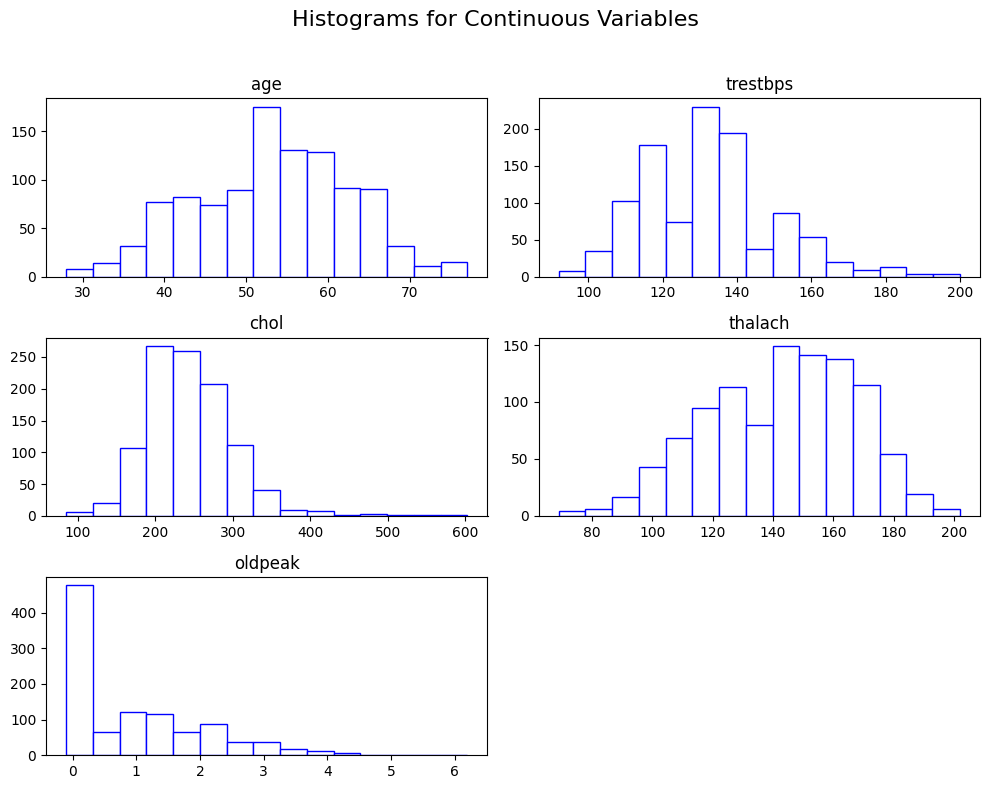

In [9]:
# Histograms for continuous variables 
# Select desired continuous columns and keep only those that actually exist in df
cols = ["age", "trestbps", "chol", "thalach", "oldpeak"]
cols = [c for c in cols if c in df.columns]

# Plot histograms; drop NaNs to avoid skewing binning/raising errors
axes = df[cols].dropna().hist(
    figsize=(10, 8),
    bins=15,
    color="white",
    edgecolor="blue"
)

# axes may be a 1D or 2D array depending on column count — flatten safely
axes = np.ravel(axes)
for ax in axes:
    ax.grid(False)  # cleaner look without grid

plt.suptitle("Histograms for Continuous Variables", fontsize=16)
# Leave space at the top for the suptitle
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

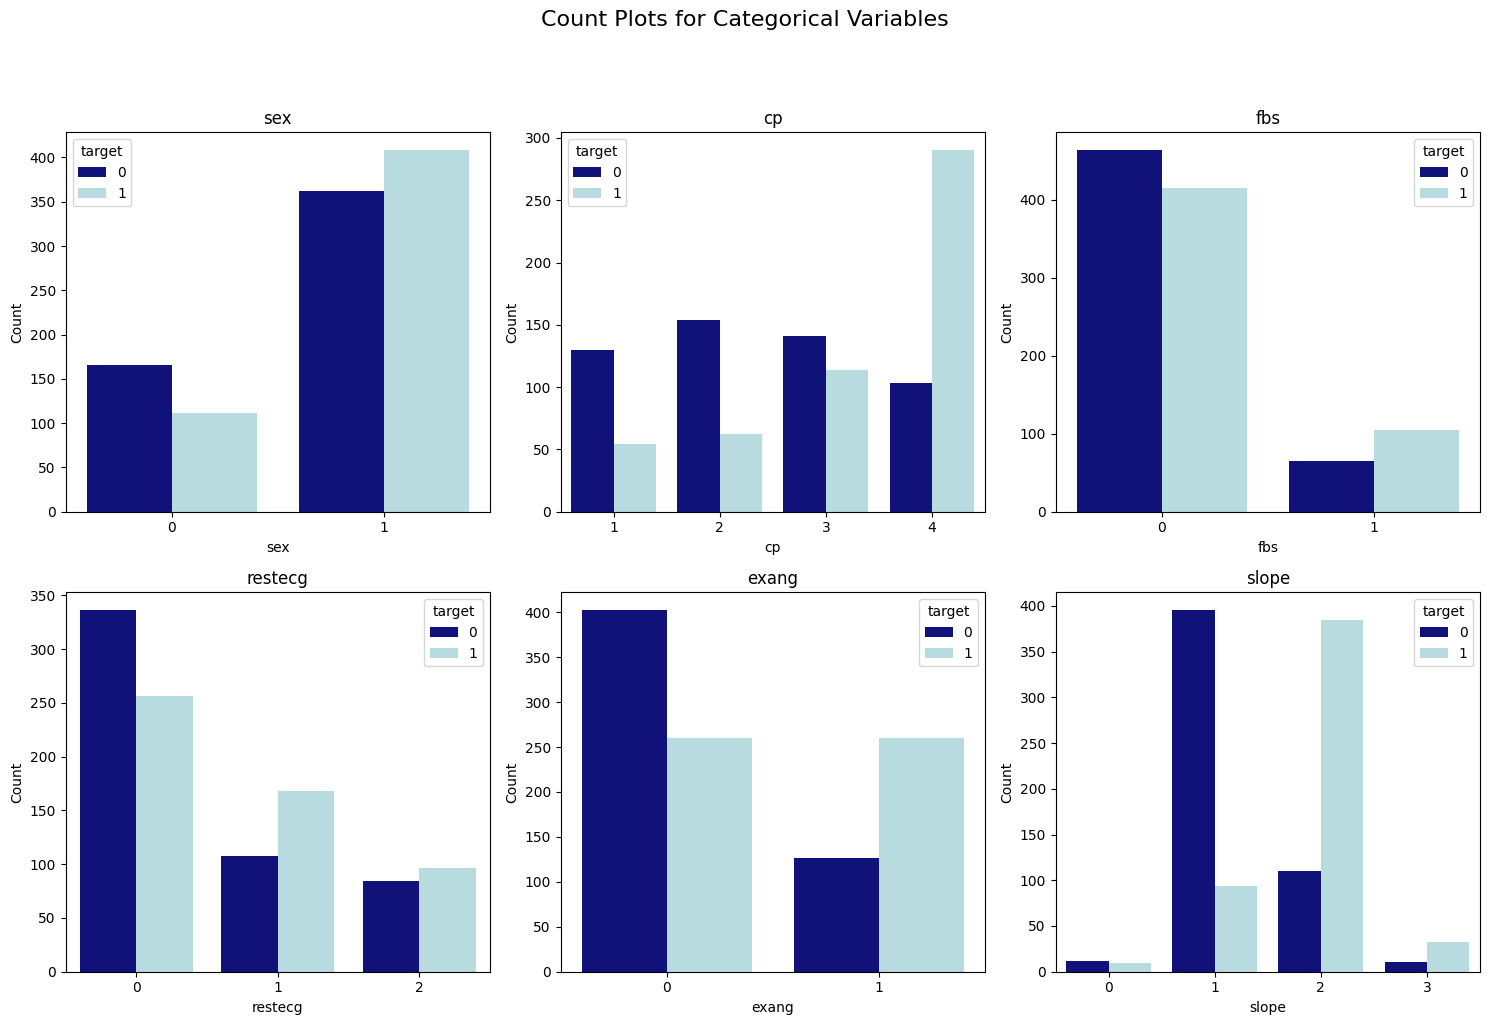

In [10]:
# count plots for categorical vars
cats = ["sex", "cp", "fbs", "restecg", "exang", "slope"]
cats = [c for c in cats if c in df.columns]  # keep only existing columns

# Fixed 2×3 grid; unused axes will be hidden below
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(cats):
    ax = axes[i]
    sns.countplot(
        data=df.dropna(subset=[col, "target"]),  # avoid NaN rows for this feature/target
        x=col,
        hue="target",
        hue_order=[0, 1],                        # consistent class order
        palette={0: "darkblue", 1: "powderblue"},
        ax=ax,
    )
    ax.set_title(f"{col}", fontsize=12)
    ax.set_xlabel(col)
    ax.set_ylabel("Count")
    ax.grid(False)

# Hide any remaining axes if fewer than 6 categorical columns are plotted
for j in range(len(cats), len(axes)):
    axes[j].set_visible(False)

plt.suptitle("Count Plots for Categorical Variables", fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.97])  # leave room for the suptitle
plt.show()

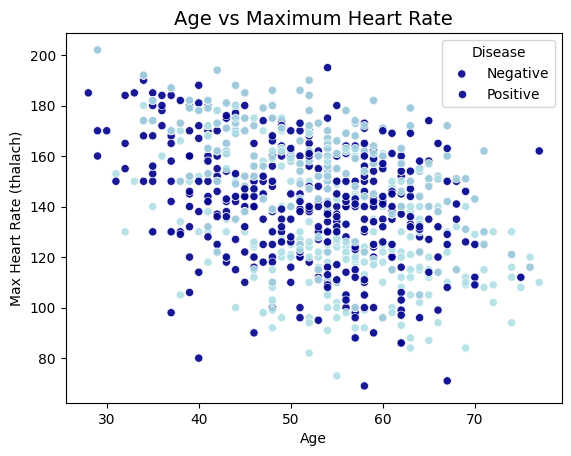

In [11]:
# Age vs Max Heart Rate
sns.scatterplot(
    data=df.dropna(subset=["age", "thalach", "target"]),
    x="age",
    y="thalach",
    hue="target",
    hue_order=[0, 1],
    palette={0: "darkblue", 1: "powderblue"},
    s=35,
    alpha=0.9,
    edgecolor="white",
    linewidth=0.5,
)
plt.title("Age vs Maximum Heart Rate", fontsize=14)
plt.xlabel("Age")
plt.ylabel("Max Heart Rate (thalach)")
plt.grid(False)
plt.legend(title="Disease", labels=["Negative", "Positive"])
plt.show()

Distribution of Target Classes:


,Count,Percent
Class,,
No Disease,528,50.4
Disease,520,49.6


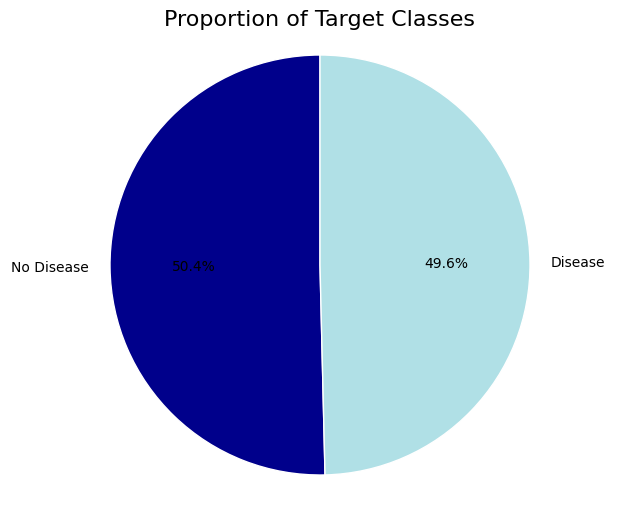

In [12]:
# target distribution (fixed class order)
order = [0, 1]
labels = {0: "No Disease", 1: "Disease"}

target_counts = df["target"].value_counts().reindex(order, fill_value=0)

print("Distribution of Target Classes:")
dist_tbl = (
    target_counts.rename_axis("Class")
    .to_frame("Count")
    .assign(Percent=lambda t: (t["Count"] / t["Count"].sum() * 100).round(1))
)
dist_tbl.index = dist_tbl.index.map(labels.get)
display(dist_tbl)

# pie chart
plt.figure(figsize=(8, 6))
plt.pie(
    target_counts.values,
    labels=[labels[i] for i in order],
    autopct="%1.1f%%",
    startangle=90,
    colors=["darkblue", "powderblue"],
    wedgeprops={"edgecolor": "white"},
)
plt.title("Proportion of Target Classes", fontsize=16)
plt.axis("equal")
plt.show()

#### Data Preprocessing

In [13]:
# split
train_df, val_df, test_df = train_val_test_split(
    df, train_ratio=0.70, val_ratio=0.15, seed=42
)
print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

# quick class balance peek
if "target" in df.columns:
    for name, part in [("Train", train_df), ("Val", val_df), ("Test", test_df)]:
        vc = part["target"].value_counts(normalize=True).sort_index() * 100
        print(f"{name} target %:", vc.round(1).to_dict())

Train: 733 | Val: 157 | Test: 158
Train target %: {0: 49.4, 1: 50.6}
Val target %: {0: 52.9, 1: 47.1}
Test target %: {0: 52.5, 1: 47.5}


In [14]:
# feature config
target_col = "target"
cat_cols   = ["sex", "cp", "fbs", "restecg", "exang", "slope"]
num_cols   = ["age", "trestbps", "chol", "thalach"]
float_cols = ["oldpeak"]

# useful later when saving artifacts
feature_order = cat_cols + num_cols + float_cols

# tiny sanity
need = feature_order + [target_col]
missing = [c for c in need if c not in df.columns]
assert not missing, f"Missing columns: {missing}"

In [15]:
# Target-encode categoricals
encoder = TargetEncoder()
train_enc = encoder.fit_transform(train_df, cat_cols, target_col)
val_enc   = encoder.transform(val_df, cat_cols)
test_enc  = encoder.transform(test_df, cat_cols)

# Standardize numeric columns
std_scaler = StandardScaler()
train_std = std_scaler.fit_transform(train_enc, num_cols)
val_std   = std_scaler.transform(val_enc, num_cols)
test_std  = std_scaler.transform(test_enc, num_cols)

# Min–max scale float columns
mm_scaler = MinMaxScaler()
train_scaled = mm_scaler.fit_transform(train_std, float_cols)
val_scaled   = mm_scaler.transform(val_std, float_cols)
test_scaled  = mm_scaler.transform(test_std, float_cols)

In [16]:
# X/y matrices (keep exact feature order)
# Reindex to the canonical feature order to avoid column misalignment across splits/runs
X_train = train_scaled.reindex(columns=feature_order, fill_value=0.0).values.astype(float)
y_train = train_df[target_col].to_numpy().reshape(-1, 1)

X_val   = val_scaled.reindex(columns=feature_order, fill_value=0.0).values.astype(float)
y_val   = val_df[target_col].to_numpy().reshape(-1, 1)

print("X_train shape:", X_train.shape, "| y_train shape:", y_train.shape)
print("X_val shape:",   X_val.shape,   "| y_val shape:",   y_val.shape)

# Tiny sanity checks to fail fast if feature alignment is broken
assert X_train.shape[1] == len(feature_order), "feature order mismatch"
assert X_val.shape[1]   == len(feature_order), "feature order mismatch"

X_train shape: (733, 11) | y_train shape: (733, 1)
X_val shape: (157, 11) | y_val shape: (157, 1)


The model was initially trained and evaluated on the training and validation sets. After confirming the model's performance, the training and validation sets were combined to retrain the model. The final evaluation was done on test data to check how well the model performs on new data.

In [17]:
# train
# Initialize the NN with input size equal to the aligned feature dimension
model = NeuralNetwork(input_dim=X_train.shape[1])

# Fit with AdamW, gradient clipping, LR scheduling, and early stopping
train_model(
    model=model,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    epochs=20,
    batch_size=64,
    lr=1e-3,
    # Demonstrative: these are defaults in nn_from_scratch (explicit here for clarity)
    use_adamw=True,       # AdamW optimizer (decoupled weight decay)
    weight_decay=1e-4,    # L2-style regularization via AdamW
    grad_clip=1.0,        # clip total gradient norm for stability
    es_patience=5,        # early stop if val loss doesn't improve
    sch_patience=2,       # LR scheduler patience before reducing LR
    sch_factor=0.5,       # multiply LR by 0.5 on plateau
)

# Ensure evaluation mode after training so dropout is disabled at inference
model.training = False

Epoch [1/20] Train Loss: 0.6893 | Val Loss: 0.6904 | AUC-ROC: 0.682 | AUC-PR: 0.587 | F1*thr=0.01 (F1=0.641) | Acc@0.5: 0.529 | MCC@0.5: 0.103 | Acc@* : 0.471 | MCC@* : 0.000
Epoch [2/20] Train Loss: 0.6838 | Val Loss: 0.6891 | AUC-ROC: 0.675 | AUC-PR: 0.582 | F1*thr=0.01 (F1=0.641) | Acc@0.5: 0.516 | MCC@0.5: 0.103 | Acc@* : 0.471 | MCC@* : 0.000
Epoch [3/20] Train Loss: 0.6750 | Val Loss: 0.6886 | AUC-ROC: 0.674 | AUC-PR: 0.581 | F1*thr=0.01 (F1=0.641) | Acc@0.5: 0.529 | MCC@0.5: 0.126 | Acc@* : 0.471 | MCC@* : 0.000
Epoch [4/20] Train Loss: 0.6640 | Val Loss: 0.6852 | AUC-ROC: 0.681 | AUC-PR: 0.587 | F1*thr=0.01 (F1=0.641) | Acc@0.5: 0.548 | MCC@0.5: 0.135 | Acc@* : 0.471 | MCC@* : 0.000
Epoch [5/20] Train Loss: 0.6550 | Val Loss: 0.6756 | AUC-ROC: 0.687 | AUC-PR: 0.597 | F1*thr=0.01 (F1=0.641) | Acc@0.5: 0.561 | MCC@0.5: 0.128 | Acc@* : 0.471 | MCC@* : 0.000
Epoch [6/20] Train Loss: 0.6427 | Val Loss: 0.6664 | AUC-ROC: 0.696 | AUC-PR: 0.610 | F1*thr=0.01 (F1=0.641) | Acc@0.5: 0.611

In [18]:
# merge train+val for final preprocessing fit
merged_train_val = pd.concat([train_df, val_df], ignore_index=True)

# Refit preprocessors on Train+Val (better stats for deployment). Test is transform-only.
final_encoder = TargetEncoder()
merged_enc = final_encoder.fit_transform(merged_train_val, cat_cols, target_col)
test_enc2   = final_encoder.transform(test_df, cat_cols)

final_std_scaler = StandardScaler()
merged_std = final_std_scaler.fit_transform(merged_enc, num_cols)
test_std2  = final_std_scaler.transform(test_enc2, num_cols)

final_mm_scaler = MinMaxScaler()
merged_scaled     = final_mm_scaler.fit_transform(merged_std, float_cols)
final_test_scaled = final_mm_scaler.transform(test_std2, float_cols)

# Enforce strict feature order so train/val/test/inference always match
# Keep target_col for downstream label extraction
merged_scaled     = merged_scaled.reindex(columns=feature_order + [target_col], fill_value=0.0)
final_test_scaled = final_test_scaled.reindex(columns=feature_order + [target_col], fill_value=0.0)

In [19]:
# merge train+val for final preprocessing fit
merged_train_val = pd.concat([train_df, val_df], ignore_index=True)

# Refit preprocessors on Train+Val (better stats for deployment). Test is transform-only.
final_encoder = TargetEncoder()
merged_enc = final_encoder.fit_transform(merged_train_val, cat_cols, target_col)
test_enc2   = final_encoder.transform(test_df, cat_cols)

final_std_scaler = StandardScaler()
merged_std = final_std_scaler.fit_transform(merged_enc, num_cols)
test_std2  = final_std_scaler.transform(test_enc2, num_cols)

final_mm_scaler = MinMaxScaler()
merged_scaled     = final_mm_scaler.fit_transform(merged_std, float_cols)
final_test_scaled = final_mm_scaler.transform(test_std2, float_cols)

# Enforce strict feature order so train/val/test/inference always match
# Keep target_col for downstream label extraction
merged_scaled     = merged_scaled.reindex(columns=feature_order + [target_col], fill_value=0.0)
final_test_scaled = final_test_scaled.reindex(columns=feature_order + [target_col], fill_value=0.0)

In [21]:
# Build final design matrices for the last training phase and the held-out evaluation set

# Features for train+val: drop the label column (if present), keep raw numpy array
X_train_val = merged_scaled.drop(columns=[target_col], errors="ignore").values
# Labels for train+val: take the target column and make it a column vector (N, 1)
y_train_val = merged_scaled[target_col].values.reshape(-1, 1)

# Features for test (holdout): same logic—no target column in X
X_test = final_test_scaled.drop(columns=[target_col], errors="ignore").values
# Labels for test: column vector to match network’s BCE loss expectations
y_test = final_test_scaled[target_col].values.reshape(-1, 1)

# Quick sanity: confirm shapes are (N, D) for X and (N, 1) for y
print("X_train_val shape:", X_train_val.shape, "y_train_val shape:", y_train_val.shape)
print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)

X_train_val shape: (890, 11) y_train_val shape: (890, 1)
X_test shape: (158, 11) y_test shape: (158, 1)


#### Model Training

In [22]:
# final training: train on train+val, monitor on test (holdout)
model = NeuralNetwork(input_dim=X_train_val.shape[1])

train_model(
    model=model,
    X_train=X_train_val,
    y_train=y_train_val,
    X_val=X_test,   # validation reported on test here (see note on leakage)
    y_val=y_test,
    epochs=20,
    batch_size=64,
    lr=1e-3,
    # Using AdamW + grad clipping + LR scheduler + early stopping
    # NOTE: If you want the test set to remain completely untouched,
    # avoid using it for callbacks (scheduler/early-stopping). Here it *does* influence training.
    use_adamw=True,
    weight_decay=1e-4,
    grad_clip=1.0,
    es_patience=5,
    sch_patience=2,
    sch_factor=0.5,
)

# ensure eval mode after training so dropout is disabled for inference/export
model.training = False


Epoch [1/20] Train Loss: 0.6903 | Val Loss: 0.6909 | AUC-ROC: 0.699 | AUC-PR: 0.636 | F1*thr=0.01 (F1=0.644) | Acc@0.5: 0.487 | MCC@0.5: 0.046 | Acc@* : 0.475 | MCC@* : 0.000
Epoch [2/20] Train Loss: 0.6858 | Val Loss: 0.6883 | AUC-ROC: 0.715 | AUC-PR: 0.643 | F1*thr=0.01 (F1=0.644) | Acc@0.5: 0.481 | MCC@0.5: 0.015 | Acc@* : 0.475 | MCC@* : 0.000
Epoch [3/20] Train Loss: 0.6797 | Val Loss: 0.6822 | AUC-ROC: 0.720 | AUC-PR: 0.653 | F1*thr=0.01 (F1=0.644) | Acc@0.5: 0.544 | MCC@0.5: 0.156 | Acc@* : 0.475 | MCC@* : 0.000
Epoch [4/20] Train Loss: 0.6705 | Val Loss: 0.6734 | AUC-ROC: 0.729 | AUC-PR: 0.662 | F1*thr=0.01 (F1=0.644) | Acc@0.5: 0.570 | MCC@0.5: 0.183 | Acc@* : 0.475 | MCC@* : 0.000
Epoch [5/20] Train Loss: 0.6590 | Val Loss: 0.6624 | AUC-ROC: 0.739 | AUC-PR: 0.672 | F1*thr=0.01 (F1=0.644) | Acc@0.5: 0.595 | MCC@0.5: 0.226 | Acc@* : 0.475 | MCC@* : 0.000
Epoch [6/20] Train Loss: 0.6444 | Val Loss: 0.6413 | AUC-ROC: 0.751 | AUC-PR: 0.692 | F1*thr=0.01 (F1=0.644) | Acc@0.5: 0.627

#### Model Evaluation 

In [23]:
## test metrics: sklearn + our helpers

pred_proba = model.forward(X_test).ravel()  # (N,) probabilities in [0,1]
y_true     = y_test.ravel()                 # (N,) integer labels

# Baseline at 0.5: familiar text report from sklearn
pred_05 = (pred_proba >= 0.5).astype(int)
print("sklearn classification_report @0.5")
print(classification_report(y_true, pred_05, digits=3))

# Find threshold that maximizes F1 (on test here for demo)
thr_opt, f1_opt = tune_threshold(y_true, pred_proba, strategy="f1")

def f1(p, r):
    return 0.0 if (p + r) == 0 else 2 * p * r / (p + r)

# Metrics at 0.5 and at best-F1 using our helper
m_05  = compute_metrics_from_probs(pred_proba, y_true, thr=0.5)
m_opt = compute_metrics_from_probs(pred_proba, y_true, thr=thr_opt)

# Threshold-free curves (same in both rows)
auc_roc = roc_auc(y_true, pred_proba)
auc_pr  = pr_auc(y_true, pred_proba)

# Tidy summary table for side-by-side comparison
report_df = pd.DataFrame([
    {
        "set": "@0.5",
        "accuracy":  m_05["accuracy"],
        "precision": m_05["precision"],
        "recall":    m_05["recall"],
        "f1":        f1(m_05["precision"], m_05["recall"]),
        "mcc":       m_05["mcc"],
        "auc_roc":   auc_roc,
        "auc_pr":    auc_pr,
        "threshold": 0.50,
    },
    {
        "set": "@best-F1",
        "accuracy":  m_opt["accuracy"],
        "precision": m_opt["precision"],
        "recall":    m_opt["recall"],
        "f1":        f1_opt,
        "mcc":       m_opt["mcc"],
        "auc_roc":   auc_roc,
        "auc_pr":    auc_pr,
        "threshold": float(thr_opt),
    },
])

display(
    report_df
      .set_index("set")
      .round(3)
      .style
      .hide(axis="index", subset=None)  # hide the index for a cleaner look
)

sklearn classification_report @0.5
              precision    recall  f1-score   support

           0      0.813     0.735     0.772        83
           1      0.735     0.813     0.772        75

    accuracy                          0.772       158
   macro avg      0.774     0.774     0.772       158
weighted avg      0.776     0.772     0.772       158



accuracy,precision,recall,f1,mcc,auc_roc,auc_pr,threshold
0.772000,0.735000,0.813000,0.772000,0.548000,0.872000,0.813000,0.500000
0.791000,0.769000,0.800000,0.784000,0.582000,0.872000,0.813000,0.570000


For evaluation recall will be considered, it is particularly important because the dataset deals with heart disease prediction, where false negatives (failing to identify patients with heart disease) can have severe consequences. The recall for the positive class (patients with heart disease) is 0.81, meaning the model correctly identifies 81% of actual cases, reducing the likelihood of missing high-risk individuals. The confusion matrix shows that while the model correctly classifies 61 cases of heart disease, it still misclassifies 14 cases as negative. The Matthews Correlation Coefficient (MCC) of 0.56 indicates a moderate correlation between predictions and actual labels, reflecting that the model performs reasonably well.

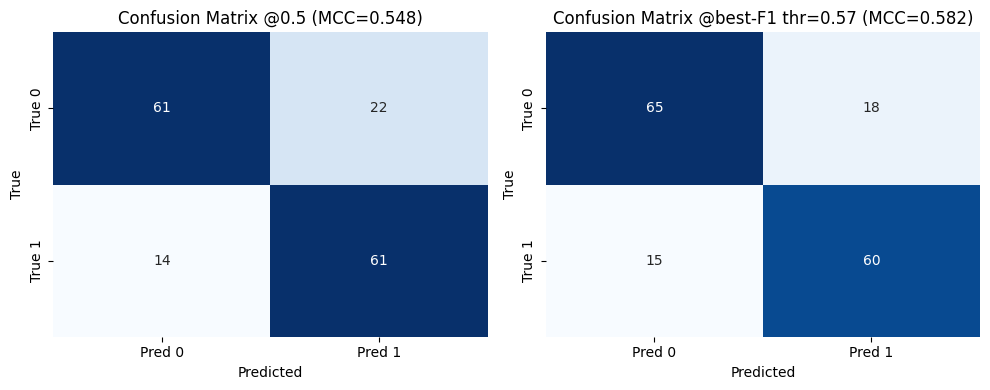

In [24]:
pred_proba = model.forward(X_test).ravel()
y_true = y_test.ravel()

# Two operating points: fixed 0.5 vs threshold tuned for best F1
thr_opt, _ = tune_threshold(y_true, pred_proba, strategy="f1")
y_pred_05  = (pred_proba >= 0.5).astype(int)
y_pred_opt = (pred_proba >= thr_opt).astype(int)

# Confusion matrices with explicit label order to keep cell meaning stable
cm_05  = confusion_matrix(y_true, y_pred_05,  labels=[0,1])
cm_opt = confusion_matrix(y_true, y_pred_opt, labels=[0,1])

# MCC is robust to class imbalance; we show it in titles for quick comparison
mcc_05  = matthews_corrcoef(y_true, y_pred_05)
mcc_opt = matthews_corrcoef(y_true, y_pred_opt)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Left: fixed 0.5
sns.heatmap(
    cm_05, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[0],
    xticklabels=["Pred 0","Pred 1"], yticklabels=["True 0","True 1"]
)
axes[0].set_title(f"Confusion Matrix @0.5 (MCC={mcc_05:.3f})")
axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("True")

# Right: tuned threshold (best-F1)
sns.heatmap(
    cm_opt, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[1],
    xticklabels=["Pred 0","Pred 1"], yticklabels=["True 0","True 1"]
)
axes[1].set_title(f"Confusion Matrix @best-F1 thr={thr_opt:.2f} (MCC={mcc_opt:.3f})")
axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("True")

plt.tight_layout()
plt.show()

#### Saving the model and Preprocessing

In [25]:
from pathlib import Path
import pickle

MODEL_DIR = Path("model")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Keep the exact training feature order for deterministic inference
feature_order = cat_cols + num_cols + float_cols

# Serialize trained model weights/structure
with open(MODEL_DIR / "model.pkl", "wb") as f:
    pickle.dump(model, f)

# Serialize preprocessing pipeline and schema
with open(MODEL_DIR / "preprocessing.pkl", "wb") as f:
    pickle.dump({
        "encoder": final_encoder,         # target encoder fitted on train+val
        "std_scaler": final_std_scaler,   # standardization for numeric columns
        "mm_scaler": final_mm_scaler,     # min-max for float columns
        "cat_cols": cat_cols,
        "num_cols": num_cols,
        "float_cols": float_cols,
        "feature_order": feature_order,   # critical: preserves column order at inference
        "artifact_version": "1.0"         # optional metadata for future-proofing
    }, f)